In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_preparation as dp
import source.modelling_utils as utils
import source.models_classification as modl


In [2]:
# simulate
df, _, _ = dp.simulate_hmm_equity_premium(
    n_samples=500,
    target="state_t_plus_1",  # forecast next state
    make_features=True,
    vol_windows=(20,60),
    mean_windows=(20,),
    start_date="1970-01-01",
    p_bull_to_bear = 0.12,  # lower -> more persistent bull
    p_bear_to_bull = 0.12,  # bear lasts shorter on avg
    seed = 43, 
)

# choose features (you can add more)


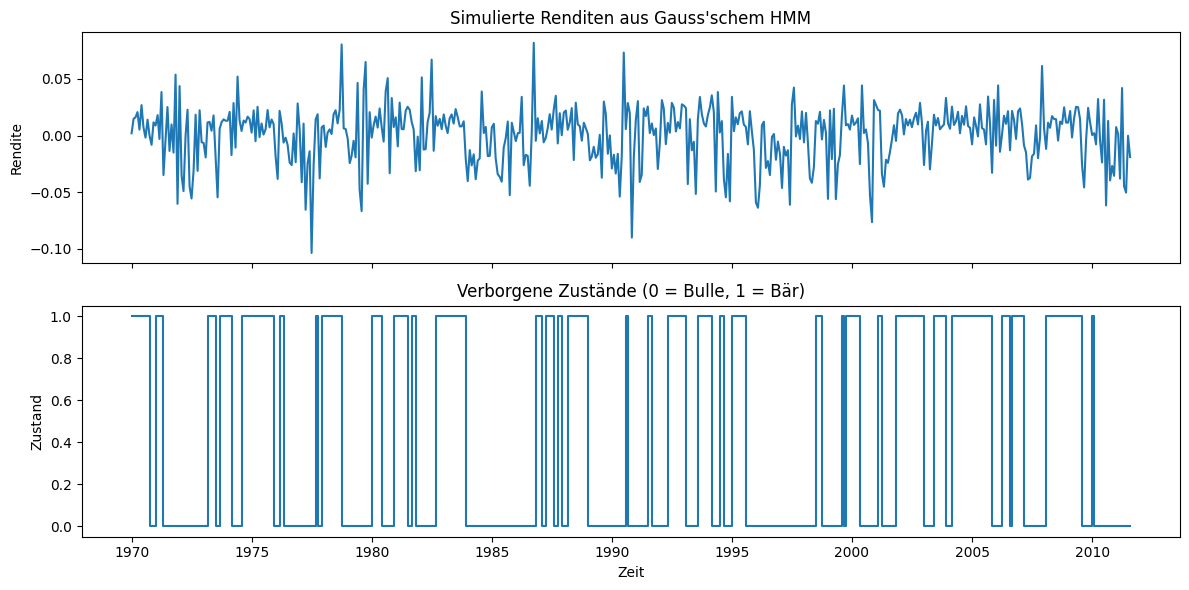

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# (1) Renditen
ax[0].plot(df["timestamp"], df["equity_premium"].values)
ax[0].set_title("Simulierte Renditen aus Gauss'schem HMM")
ax[0].set_ylabel("Rendite")

# (2) Hidden States (0 = Bulle, 1 = Bär)
ax[1].step(df["timestamp"], df["state_true"].values, where="post")
ax[1].set_title("Verborgene Zustände (0 = Bulle, 1 = Bär)")
ax[1].set_xlabel("Zeit")
ax[1].set_ylabel("Zustand")

plt.tight_layout()
plt.show()


In [32]:
logit_lag_fit_predict = modl.make_logit_multifeature_lag_fit_predict_fn(base_cols = ["equity_premium", "abs_ret", "rv20", "rv60", "ma20"],                # multiple continuous input variables
    target_col = "state_true",n_lags = 4                # use 5 lags for each variable
    )
metrics, y_true, y_pred, dates = utils.expanding_oos_tabular_cls(
    data=df,
    target_col="state_true",
    model_fit_predict_fn=logit_lag_fit_predict,
    start_oos="2007-01-01",
    start_date="1850-01-01",
    baseline_mode = 'majority'
)
print(metrics)

2007-01-01 00:00:00
[1]
2007-02-01 00:00:00
[1]
2007-03-01 00:00:00
[1]
2007-04-01 00:00:00
[1]
2007-05-01 00:00:00
[1]
2007-06-01 00:00:00
[1]
2007-07-01 00:00:00
[1]
2007-08-01 00:00:00
[1]
2007-09-01 00:00:00
[1]
2007-10-01 00:00:00
[1]
2007-11-01 00:00:00
[1]
2007-12-01 00:00:00
[1]
2008-01-01 00:00:00
[1]
2008-02-01 00:00:00
[1]
2008-03-01 00:00:00
[1]
2008-04-01 00:00:00
[1]
2008-05-01 00:00:00
[1]
2008-06-01 00:00:00
[1]
2008-07-01 00:00:00
[1]
2008-08-01 00:00:00
[1]
2008-09-01 00:00:00
[1]
2008-10-01 00:00:00
[1]
2008-11-01 00:00:00
[1]
2008-12-01 00:00:00
[1]
2009-01-01 00:00:00
[1]
2009-02-01 00:00:00
[1]
2009-03-01 00:00:00
[1]
2009-04-01 00:00:00
[1]
2009-05-01 00:00:00
[1]
2009-06-01 00:00:00
[1]
2009-07-01 00:00:00
[1]
2009-08-01 00:00:00
[1]
2009-09-01 00:00:00
[1]
2009-10-01 00:00:00
[1]
2009-11-01 00:00:00
[1]
2009-12-01 00:00:00
[1]
2010-01-01 00:00:00
[1]
2010-02-01 00:00:00
[1]
2010-03-01 00:00:00
[1]
2010-04-01 00:00:00
[1]
2010-05-01 00:00:00
[1]
2010-06-01 00:00

(array([ 969.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1087.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

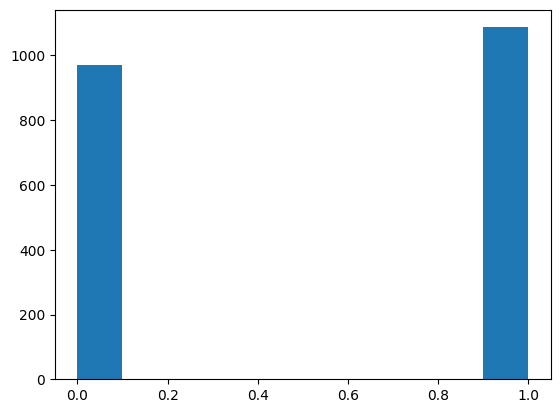

In [33]:
plt.hist(y_true)


(array([ 336.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1720.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

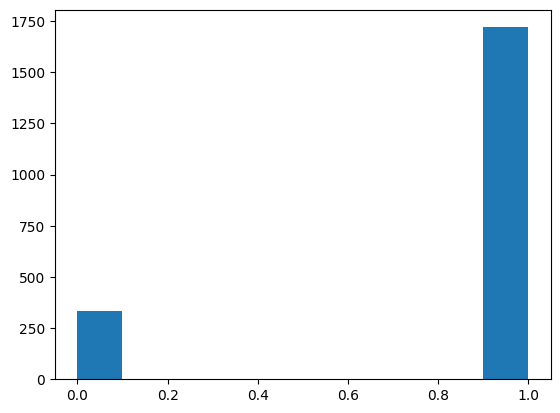

In [34]:
plt.hist(y_pred)

In [24]:
from importlib import reload
reload(modl)

<module 'source.models_classification' from '/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py'>

In [15]:
base_cols = ["equity_premium", "abs_ret", "rv20", "rv60", "ma20"]
metrics, y_true, y_pred, dates = modl.tabpfn_cls_oos(
    data = df,
    base_cols = base_cols,
    target_col="state_true",
    
    start_oos="2007-01-01",
    start_date="1850-01-01",
    
    n_lags= 1,
    min_train = 120,
    quiet = False,
    model_name = "TabPFN-CLS-lag",
    baseline_mode = "majority",
    model_params=None,           # e.g. "2.5"
)

RuntimeError: TabPFN not installed. Please `pip install tabpfn`.

In [ ]:
plt.hist(y_pred)

In [35]:
fit_fn = modl.make_moment_fit_predict_fn(
    feature_cols=["equity_premium", "abs_ret", "rv20", "rv60", "ma20"],   # or a list of your channels
    target_col="state_true",
    seq_len=8,
    epochs=30,
    tune_threshold="youden",           # or "majority" or None
    retrain_every=100,
    batch_size=64,
    use_class_weight=True
)

metrics, y_true, y_pred, dates = utils.expanding_oos_tabular_cls(
    data=df,
    target_col="state_true",
    start_oos="2007-01-01",
    start_date="1850-01-01",
    min_train=256,                     # recommend >= seq_len
    model_name="MOMENT-CLS",
    model_fit_predict_fn=fit_fn,
    baseline_mode="majority",
)


2007-01-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.689759
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.670650
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.660145
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.630245
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.640357
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.623181
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.609726
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.608913
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.599756
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.605711
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.601466
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.598375
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.599296
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.581129
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.589284
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.581734
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.588879
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.581611
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.576318
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.759384
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.726539
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.669509
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.668692
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.644218
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.630401
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.627440
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.611012
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.603053
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.599101
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.604792
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.606928
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.599961
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.604627
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.590761
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.593740
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.578627
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.589321
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.587212
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.708491
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.698862
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.666340
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.656258
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.644456
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.628467
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.613604
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.613273
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.608024
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.591692
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.599070
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.588032
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.581120
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.584433
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.584567
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.579367
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.581431
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.573476
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.581540
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.707846
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.683592
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.663461
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.656137
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.633379
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.635828
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.615619
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.608471
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.604706
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.606465
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.597915
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.601268
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.589620
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.598642
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.585732
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.578549
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.583530
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.577184
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.590662
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.678282
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.670001
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.655256
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.641877
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.613315
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.620846
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.591999
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.607524
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.604347
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.586936
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.579667
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.578127
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.585987
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.575110
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.555836
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.596393
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.574460
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.558386
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.551151
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.710485
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.676808
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.649363
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.632611
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.624334
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.608191
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.595405
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.598837
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.590032
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.584348
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.579569
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.581314
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.572738
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.567964
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.570624
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.567834
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.568967
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.566643
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.564127
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.710791
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.672007
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.642862
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.613619
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.613945
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.600636
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.594786
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.586488
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.577909
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.583802
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.573444
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.582334
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.585567
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.576681
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.577506
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.570040
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.564522
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.575466
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.572724
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.697380
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.672000
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.647840
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.636582
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.626199
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.615127
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.610788
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.605388
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.596640
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.595960
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.598086
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.592841
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.598070
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.600188
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.584555
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.580227
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.588910
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.583720
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.582818
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.703273
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.678187
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.658358
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.645259
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.627732
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.625907
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.605987
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.607578
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.605227
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.604675
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.600090
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.599493
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.597469
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.600516
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.601693
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.587308
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.606928
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.585377
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.590071
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.711152
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.688826
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.652117
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.646780
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.629911
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.623882
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.620776
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.617511
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.617893
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.610123
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.607340
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.601603
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.596266
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.603196
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.605133
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.599281
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.607245
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.594782
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.597244
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.679935
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.663713
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.640011
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.629259
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.619385
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.612943
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.607640
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.607653
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.605753
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.601805
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.599951
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.600679
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.600142
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.594804
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.589918
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.591433
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.591204
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.590584
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.598080
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.693215
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.664373
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.639829
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.631944
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.626181
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.612121
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.607017
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.605820
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.600352
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.595021
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.598155
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.601793
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.594869
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.595630
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.595886
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.592401
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.596484
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.590920
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.594295
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.697629
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.672747
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.650011
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.630970
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.617765
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.608824
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.609855
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.605842
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.601584
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.601464
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.598110
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.597047
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.597873
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.594984
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.597585
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.590910
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.590321
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.593257
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.591186
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.690476
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.666503
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.644260
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.633614
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.621477
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.619247
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.613108
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.612495
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.602104
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.605744
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.599382
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.602226
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.603828
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.603129
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.602900
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.599726
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.597190
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.599660
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.591237
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.703677
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.667472
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.645640
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.628308
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.619531
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.619795
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.608918
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.610170
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.607035
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.600797
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.606322
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.603864
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.605854
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.608223
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.596561
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.602251
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.600037
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.599716
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.601776
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.682592
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.663390
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.641020
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.627134
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.618990
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.620268
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.610956
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.620062
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.609078
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.605763
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.606859
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.602362
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.608945
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.599739
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.600390
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.596666
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.600714
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.600695
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.604264
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.692889
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.657230
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.637884
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.627699
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.617840
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.614798
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.611361
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.597126
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.612974
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.599544
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.600016
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.602374
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.601974
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.600248
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.598848
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.601392
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.592690
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.602649
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.597219
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.711029
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.663072
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.638163
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.626652
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.624824
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.617618
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.616103
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.605326
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.602268
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.605815
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.607878
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.600663
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.607222
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.601558
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.600642
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.602520
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.593816
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.600065
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.597293
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.694367
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.662436
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.638456
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.626532
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.615598
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.610479
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.606478
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.601401
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.604040
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.602136
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.598319
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.603360
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.598895
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.597790
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.598725
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.598353
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.597438
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.595660
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.593213
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.709805
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.663308
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.638153
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.620755
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.616384
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.610788
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.607924
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.602019
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.601293
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.600841
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.600819
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.601716
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.599105
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.599709
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.596408
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.598495
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.600315
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.596024
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.594112
[MOMENT retrain] Epoch 20/30 | Avg loss 

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


[MOMENT retrain] Epoch 1/30 | Avg loss = 0.702875
[MOMENT retrain] Epoch 2/30 | Avg loss = 0.654935
[MOMENT retrain] Epoch 3/30 | Avg loss = 0.639471
[MOMENT retrain] Epoch 4/30 | Avg loss = 0.631699
[MOMENT retrain] Epoch 5/30 | Avg loss = 0.624586
[MOMENT retrain] Epoch 6/30 | Avg loss = 0.620664
[MOMENT retrain] Epoch 7/30 | Avg loss = 0.606024
[MOMENT retrain] Epoch 8/30 | Avg loss = 0.608365
[MOMENT retrain] Epoch 9/30 | Avg loss = 0.599231
[MOMENT retrain] Epoch 10/30 | Avg loss = 0.602923
[MOMENT retrain] Epoch 11/30 | Avg loss = 0.602549
[MOMENT retrain] Epoch 12/30 | Avg loss = 0.589046
[MOMENT retrain] Epoch 13/30 | Avg loss = 0.600092
[MOMENT retrain] Epoch 14/30 | Avg loss = 0.604301
[MOMENT retrain] Epoch 15/30 | Avg loss = 0.583708
[MOMENT retrain] Epoch 16/30 | Avg loss = 0.593581
[MOMENT retrain] Epoch 17/30 | Avg loss = 0.593839
[MOMENT retrain] Epoch 18/30 | Avg loss = 0.591054
[MOMENT retrain] Epoch 19/30 | Avg loss = 0.591447
[MOMENT retrain] Epoch 20/30 | Avg loss 

In [ ]:
plt.hist(y_prob)

In [61]:
# Example: XGB/GBM lag classifier
fit_fn = modl.make_tree_ensemble_lag_cls_fit_predict_fn(
    base_cols=["equity_premium", "abs_ret", "rv20", "rv60", "ma20"],
    target_col="state_true",
    n_lags=6,
    class_weight="balanced",
    model_params={"n_estimators": 500, "max_depth": 3},
    return_proba=False,
)

metrics, y_true, y_pred, dates = utils.expanding_oos_tabular_cls(
    data=df,
    target_col="state_true",
    start_oos="2007-01-01",
    start_date="1850-01-01",
    min_train=120,
    model_name="XGB-lag6",
    model_fit_predict_fn=fit_fn,
    baseline_mode="majority",
    quiet=False,
)


2007-01-01 00:00:00
2007-02-01 00:00:00
2007-03-01 00:00:00
2007-04-01 00:00:00
2007-05-01 00:00:00
2007-06-01 00:00:00
2007-07-01 00:00:00
2007-08-01 00:00:00
2007-09-01 00:00:00
2007-10-01 00:00:00
2007-11-01 00:00:00
2007-12-01 00:00:00
2008-01-01 00:00:00
2008-02-01 00:00:00
2008-03-01 00:00:00
2008-04-01 00:00:00
2008-05-01 00:00:00
2008-06-01 00:00:00
2008-07-01 00:00:00
2008-08-01 00:00:00
2008-09-01 00:00:00
2008-10-01 00:00:00
2008-11-01 00:00:00
2008-12-01 00:00:00
2009-01-01 00:00:00
2009-02-01 00:00:00
2009-03-01 00:00:00
2009-04-01 00:00:00
2009-05-01 00:00:00
2009-06-01 00:00:00
2009-07-01 00:00:00
2009-08-01 00:00:00
2009-09-01 00:00:00
2009-10-01 00:00:00
2009-11-01 00:00:00
2009-12-01 00:00:00
2010-01-01 00:00:00
2010-02-01 00:00:00
2010-03-01 00:00:00
2010-04-01 00:00:00
2010-05-01 00:00:00
2010-06-01 00:00:00
2010-07-01 00:00:00
2010-08-01 00:00:00
2010-09-01 00:00:00
2010-10-01 00:00:00
2010-11-01 00:00:00
2010-12-01 00:00:00
2011-01-01 00:00:00
2011-02-01 00:00:00


(array([55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

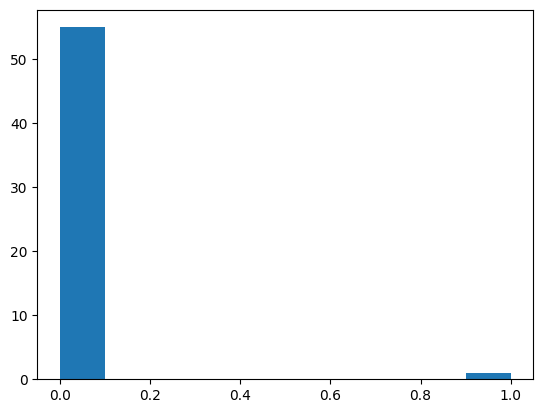

In [42]:
plt.hist(y_pred)

In [ ]:
fit_fn = modl.make_mlp_lag_cls_fit_predict_fn(
    base_cols=["equity_premium", "abs_ret", "rv20", "rv60", "ma20"],
    target_col="state_true",
    n_lags=6,
    retrain_every=5,
    class_weight= True,
)

metrics, y_true, y_pred, dates = utils.expanding_oos_tabular_cls(
    data=df,
    target_col="state_true",
    start_oos="2007-01-01",
    start_date="1850-01-01",
    min_train=120,
    model_name="XGB-lag6",
    model_fit_predict_fn=fit_fn,
    baseline_mode="majority",
    quiet=False,
)


2007-01-01 00:00:00
[MLPCls retrain] epoch 1/5 | loss=0.576418
[MLPCls retrain] epoch 2/5 | loss=0.572152
[MLPCls retrain] epoch 3/5 | loss=0.568218
[MLPCls retrain] epoch 4/5 | loss=0.563478
[MLPCls retrain] epoch 5/5 | loss=0.558352
2007-02-01 00:00:00
2007-03-01 00:00:00
2007-04-01 00:00:00
2007-05-01 00:00:00
[MLPCls retrain] epoch 1/5 | loss=0.570489
[MLPCls retrain] epoch 2/5 | loss=0.567918
[MLPCls retrain] epoch 3/5 | loss=0.565113
[MLPCls retrain] epoch 4/5 | loss=0.562310
[MLPCls retrain] epoch 5/5 | loss=0.558747
2007-06-01 00:00:00
2007-07-01 00:00:00
2007-08-01 00:00:00
2007-09-01 00:00:00
2007-10-01 00:00:00
[MLPCls retrain] epoch 1/5 | loss=0.570810
[MLPCls retrain] epoch 2/5 | loss=0.581213
[MLPCls retrain] epoch 3/5 | loss=0.547162
[MLPCls retrain] epoch 4/5 | loss=0.560751
[MLPCls retrain] epoch 5/5 | loss=0.554754
2007-11-01 00:00:00
2007-12-01 00:00:00
2008-01-01 00:00:00
2008-02-01 00:00:00
2008-03-01 00:00:00
[MLPCls retrain] epoch 1/5 | loss=0.595211
[MLPCls retr

In [23]:
fit_fn = modl.make_mlp_lag_cls_fit_predict_fn(
    base_cols=["equity_premium"],
    target_col="state_true",
    n_lags=100,
    retrain_every=5,
    class_weight= True,
)

metrics, y_true, y_pred, dates = utils.expanding_oos_tabular_cls(
    data=df,
    target_col="state_true",
    start_oos="2007-01-01",
    start_date="1850-01-01",
    min_train=120,
    model_name="XGB-lag6",
    model_fit_predict_fn=fit_fn,
    baseline_mode="majority",
    quiet=False,
)


2007-01-01 00:00:00
[MLPCls retrain] epoch 1/5 | loss=0.645068
[MLPCls retrain] epoch 2/5 | loss=0.639736
[MLPCls retrain] epoch 3/5 | loss=0.635001
[MLPCls retrain] epoch 4/5 | loss=0.631457
[MLPCls retrain] epoch 5/5 | loss=0.627261
2007-02-01 00:00:00
2007-03-01 00:00:00


/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

2007-04-01 00:00:00
2007-05-01 00:00:00
[MLPCls retrain] epoch 1/5 | loss=0.630397
[MLPCls retrain] epoch 2/5 | loss=0.628719
[MLPCls retrain] epoch 3/5 | loss=0.627306
[MLPCls retrain] epoch 4/5 | loss=0.623665
[MLPCls retrain] epoch 5/5 | loss=0.620609
2007-06-01 00:00:00
2007-07-01 00:00:00
2007-08-01 00:00:00
2007-09-01 00:00:00
2007-10-01 00:00:00


/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

[MLPCls retrain] epoch 1/5 | loss=0.639484
[MLPCls retrain] epoch 2/5 | loss=0.636525
[MLPCls retrain] epoch 3/5 | loss=0.633366
[MLPCls retrain] epoch 4/5 | loss=0.630177
[MLPCls retrain] epoch 5/5 | loss=0.627125
2007-11-01 00:00:00
2007-12-01 00:00:00
2008-01-01 00:00:00
2008-02-01 00:00:00
2008-03-01 00:00:00


/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

[MLPCls retrain] epoch 1/5 | loss=0.650766
[MLPCls retrain] epoch 2/5 | loss=0.646868
[MLPCls retrain] epoch 3/5 | loss=0.643576
[MLPCls retrain] epoch 4/5 | loss=0.640183
[MLPCls retrain] epoch 5/5 | loss=0.636005
2008-04-01 00:00:00
2008-05-01 00:00:00
2008-06-01 00:00:00
2008-07-01 00:00:00
2008-08-01 00:00:00


/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

[MLPCls retrain] epoch 1/5 | loss=0.661714
[MLPCls retrain] epoch 2/5 | loss=0.658377
[MLPCls retrain] epoch 3/5 | loss=0.655593
[MLPCls retrain] epoch 4/5 | loss=0.652348
[MLPCls retrain] epoch 5/5 | loss=0.648793
2008-09-01 00:00:00
2008-10-01 00:00:00
2008-11-01 00:00:00
2008-12-01 00:00:00
2009-01-01 00:00:00


/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

[MLPCls retrain] epoch 1/5 | loss=0.671625
[MLPCls retrain] epoch 2/5 | loss=0.667056
[MLPCls retrain] epoch 3/5 | loss=0.662891
[MLPCls retrain] epoch 4/5 | loss=0.658966
[MLPCls retrain] epoch 5/5 | loss=0.654272
2009-02-01 00:00:00
2009-03-01 00:00:00
2009-04-01 00:00:00
2009-05-01 00:00:00
2009-06-01 00:00:00


/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

[MLPCls retrain] epoch 1/5 | loss=0.683000
[MLPCls retrain] epoch 2/5 | loss=0.679541
[MLPCls retrain] epoch 3/5 | loss=0.677170
[MLPCls retrain] epoch 4/5 | loss=0.674381
[MLPCls retrain] epoch 5/5 | loss=0.671645
2009-07-01 00:00:00
2009-08-01 00:00:00
2009-09-01 00:00:00
2009-10-01 00:00:00
2009-11-01 00:00:00


/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

[MLPCls retrain] epoch 1/5 | loss=0.685325
[MLPCls retrain] epoch 2/5 | loss=0.681792
[MLPCls retrain] epoch 3/5 | loss=0.678710
[MLPCls retrain] epoch 4/5 | loss=0.675671
[MLPCls retrain] epoch 5/5 | loss=0.672081
2009-12-01 00:00:00
2010-01-01 00:00:00
2010-02-01 00:00:00
2010-03-01 00:00:00
2010-04-01 00:00:00
[MLPCls retrain] epoch 1/5 | loss=0.678488
[MLPCls retrain] epoch 2/5 | loss=0.673840
[MLPCls retrain] epoch 3/5 | loss=0.669854


/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

[MLPCls retrain] epoch 4/5 | loss=0.665674
[MLPCls retrain] epoch 5/5 | loss=0.660997
2010-05-01 00:00:00
2010-06-01 00:00:00
2010-07-01 00:00:00
2010-08-01 00:00:00
2010-09-01 00:00:00
[MLPCls retrain] epoch 1/5 | loss=0.658068
[MLPCls retrain] epoch 2/5 | loss=0.670466
[MLPCls retrain] epoch 3/5 | loss=0.658007
[MLPCls retrain] epoch 4/5 | loss=0.649821
[MLPCls retrain] epoch 5/5 | loss=0.663708
2010-10-01 00:00:00


/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

2010-11-01 00:00:00
2010-12-01 00:00:00
2011-01-01 00:00:00
2011-02-01 00:00:00
[MLPCls retrain] epoch 1/5 | loss=0.662206
[MLPCls retrain] epoch 2/5 | loss=0.642710
[MLPCls retrain] epoch 3/5 | loss=0.644498
[MLPCls retrain] epoch 4/5 | loss=0.628477
[MLPCls retrain] epoch 5/5 | loss=0.648289
2011-03-01 00:00:00
2011-04-01 00:00:00
2011-05-01 00:00:00
2011-06-01 00:00:00
2011-07-01 00:00:00
[MLPCls retrain] epoch 1/5 | loss=0.657442
[MLPCls retrain] epoch 2/5 | loss=0.658904
[MLPCls retrain] epoch 3/5 | loss=0.655585


/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

[MLPCls retrain] epoch 4/5 | loss=0.639491
[MLPCls retrain] epoch 5/5 | loss=0.633524
2011-08-01 00:00:00
[XGB-lag6] Valid obs=56 | Acc=0.3929 (baseline=0.5357) | BalAcc=0.4052 (baseline=0.4994) | Skill_Acc=-0.3077


/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")
/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py:734: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  else: device = torch.device("cpu")


In [24]:
fit_fn = modl.make_chronos_t5_cls_fit_predict_fn(
    feature_col="equity_premium",
    target_col="state_true",
    seq_len=75,                  # 128 is fine too, but 64 often enough for returns
    epochs=5,                    # 5 is fine IF we retrain often (incremental)
    retrain_every=2005,            # <--- Update weights every 25 steps
    lr=1e-3,                     # Slightly higher LR for MLP
    model_id="amazon/chronos-t5-small",
    return_proba=False,           # Better for analyzing performance
)

metrics, y_true, y_pred, dates = utils.expanding_oos_tabular_cls(
    data=df,
    target_col="state_true",
    start_oos="2007-01-01",
    # Ensure start_date gives enough history BEFORE start_oos 
    # so the first training set isn't empty.
    start_date="1850-01-01",
    min_train=200,
    model_name="Chronos-T5-Corrected",
    model_fit_predict_fn=fit_fn,
    baseline_mode="majority",
    quiet=False,
)

2007-01-01 00:00:00
[Chronos] Loading amazon/chronos-t5-small on mps...


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at amazon/chronos-t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Chronos Retrain] Step 1 | Epoch 1/5
[Chronos Retrain] Batch 2 | Loss: 0.6921
[Chronos Retrain] Batch 3 | Loss: 0.7058
[Chronos Retrain] Batch 4 | Loss: 0.7050
[Chronos Retrain] Batch 5 | Loss: 0.6888
[Chronos Retrain] Batch 6 | Loss: 0.7002
[Chronos Retrain] Batch 7 | Loss: 0.6557
[Chronos Retrain] Batch 8 | Loss: 0.6474
[Chronos Retrain] Batch 9 | Loss: 0.5607
[Chronos Retrain] Batch 10 | Loss: 0.6452
[Chronos Retrain] Batch 11 | Loss: 0.5500
[Chronos Retrain] Batch 12 | Loss: 0.5448
[Chronos Retrain] Batch 13 | Loss: 0.4756
[Chronos Retrain] Step 1 | Epoch 2/5
[Chronos Retrain] Batch 2 | Loss: 0.4739
[Chronos Retrain] Batch 3 | Loss: 0.3530
[Chronos Retrain] Batch 4 | Loss: 0.3752
[Chronos Retrain] Batch 5 | Loss: 0.2580
[Chronos Retrain] Batch 6 | Loss: 0.2226
[Chronos Retrain] Batch 7 | Loss: 0.5421
[Chronos Retrain] Batch 8 | Loss: 0.5694
[Chronos Retrain] Batch 9 | Loss: 0.4869
[Chronos Retrain] Batch 10 | Loss: 0.4833
[Chronos Retrain] Batch 11 | Loss: 0.4491
[Chronos Retrain] 

In [33]:
#[Chronos-T5-Corrected] Valid obs=616 | Acc=0.7906 (baseline=0.6104) | BalAcc=0.7983 (baseline=0.5000) | Skill_Acc=0.4625

from importlib import reload
reload(modl)

<module 'source.models_classification' from '/Users/kilianrunnwerth/Masterarbeit/source/models_classification.py'>

In [43]:

fit_fn = modl.make_chronos_forecast_mlp_cls_fn(
    feature_col="equity_premium",
    target_col="state_true",
    seq_len=100,                  # 128 is fine too, but 64 often enough for returns
    epochs = 5 ,                    # 5 is fine IF we retrain often (incremental)
    retrain_every=500,            # <--- Update weights every 25 steps
    lr=1e-3,                     # Slightly higher LR for MLP
    model_id = "amazon/chronos-bolt-tiny",    
    return_proba=False,           # Better for analyzing performance
    pred_len = 12
)

metrics, y_true, y_pred, dates = utils.expanding_oos_tabular_cls(
    data=df,
    target_col="state_true",
    start_oos="2007-01-01",
    # Ensure start_date gives enough history BEFORE start_oos 
    # so the first training set isn't empty.
    start_date="1850-01-01",
    min_train=200,
    model_name="Chronos-T5-Corrected",
    model_fit_predict_fn=fit_fn,
    baseline_mode="majority",
    quiet=False,
)

2007-01-01 00:00:00
[Chronos-MLP] Initializing on mps | pred_len=12 (0 => no Chronos)
[Chronos-MLP] Loading amazon/chronos-bolt-tiny...
2007-02-01 00:00:00
2007-03-01 00:00:00
2007-04-01 00:00:00
2007-05-01 00:00:00
2007-06-01 00:00:00
2007-07-01 00:00:00
2007-08-01 00:00:00
2007-09-01 00:00:00
2007-10-01 00:00:00
2007-11-01 00:00:00
2007-12-01 00:00:00
2008-01-01 00:00:00
2008-02-01 00:00:00
2008-03-01 00:00:00
2008-04-01 00:00:00
2008-05-01 00:00:00
2008-06-01 00:00:00
2008-07-01 00:00:00
2008-08-01 00:00:00
2008-09-01 00:00:00
2008-10-01 00:00:00
2008-11-01 00:00:00
2008-12-01 00:00:00
2009-01-01 00:00:00
2009-02-01 00:00:00
2009-03-01 00:00:00
2009-04-01 00:00:00
2009-05-01 00:00:00
2009-06-01 00:00:00
2009-07-01 00:00:00
2009-08-01 00:00:00
2009-09-01 00:00:00
2009-10-01 00:00:00
2009-11-01 00:00:00
2009-12-01 00:00:00
2010-01-01 00:00:00
2010-02-01 00:00:00
2010-03-01 00:00:00
2010-04-01 00:00:00
2010-05-01 00:00:00
2010-06-01 00:00:00
2010-07-01 00:00:00
2010-08-01 00:00:00
2010

(array([27.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

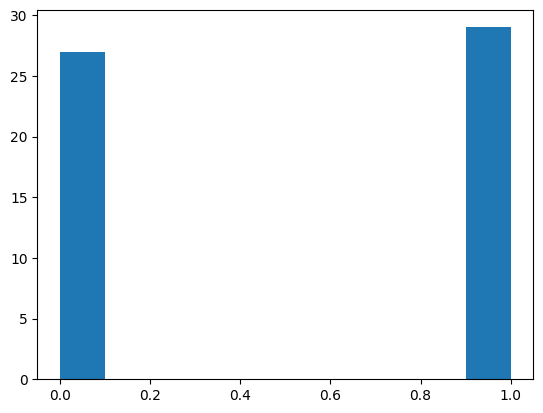

In [39]:
plt.hist(y_pred)